In [1]:

import IPython
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np 
import numpy.random as npr
import scipy as sp
import scipy.linalg as sl
from scipy.fft import fft
from scipy.fft import ifft
plt.rcParams["animation.html"]="jshtml"


In [2]:

from scipy.fft import fft2
from scipy.fft import ifft2
import time

from mpl_toolkits.mplot3d import Axes3D


### Necessaire si l'on prend Nx ou Nt grand
savefile = 5       #rajoute des pas de temps à la simulation sans les compter dans la sauvegarde
red_x = 1 ;red_y=1  #enlève des pas d'espace à la sauvegarde en les prenant en compte à la simu
# le problème est résolu sur [Nx*red_x,Ny*red_y] en Nt*savefile pas de temps 
# pour obtenir une solution film de taille [Nx,Ny] en Nt


def Norme (Nx,Ny,Lx,Ly,psi):
    return np.sqrt(Lx/Nx)*np.sqrt(Ly/Ny)*np.linalg.norm(psi)

def Projection_red (Nx,Ny,psi,red_x=red_x,red_y=red_y):
    sol_red = np.zeros((int(Nx/red_x),int(Ny/red_y)), dtype="complex")
    for i in range(0,Nx,red_x):
        for j in range(0,Ny,red_y):
            sol_red[int(i/red_x),int(j/red_y)] = psi[i,j]
    return sol_red


def Kin_2D(Nx,Ny):
    Nx_2 = int((Nx/2)*(Nx%2==0) + ((Nx-1)/2)*(Nx%2==1)) 
    Ny_2 = int((Ny/2)*(Ny%2==0) + ((Ny-1)/2)*(Ny%2==1))

    K = np.zeros((Nx,Ny), dtype='complex')
    for i in range(0,Nx_2):
        for j in range(0,Ny_2):
            K[i,j] = i*j
            
        for j in range(Ny_2,Ny):
            K[i,j] = i*(j-Ny)
    
    for i in range(Nx_2,Nx):
        for j in range(0,Ny_2):
            K[i,j] = (i-Nx)*j
            
        for j in range(Ny_2,Ny):
            K[i,j] = (i-Nx)*(j-Ny)

    K = K * 0.5*(2*np.pi/(L))**2
    return K


def dynamics_2D(psi0_fun=(lambda x,y: np.exp(-(x*x+y*y)**2)), V_fun=(lambda x,y,t: 0), Lx=10, Ly=10, Nx=100, Ny=100, T=4, Nt=100, show=True, f=(lambda x,y,t:0)):


    Kinetic = Kin_2D(Nx,Ny)
    I = np.linspace(-Lx,Lx,Nx); J = np.linspace(-Ly,Ly,Ny).reshape(-1,1)


    Psi_temp =np.zeros((Nx,Ny,2), dtype="complex"); Phi_temp = np.zeros((Nx,Ny), dtype="complex")
    Psi_temp[:,:,0]=psi0_fun(I,J)
    dt = T/Nt
    
    Psi_T = np.zeros((int(Nx/red_x),int(Ny/red_y),Nt), dtype="complex")
    if(show) : Psi_T[:,:,0]= Projection_red(Nx,Ny,Psi_temp[:,:,0])


    norm = np.sqrt(Lx/Nx)*np.sqrt(Ly/Ny)*np.linalg.norm(Psi_temp[:,:,0])
    
    diff_Norm = np.zeros(Nt); Energie = np.zeros(Nt)

    for i in range(1,savefile*Nt):
        ti = dt*i
        Phi_temp[:,:]= np.exp(-1j*Kinetic*dt)* fft2(np.exp(-1j*V_fun(I,J,ti)*dt) *Psi_temp[:,:,0])
        Psi_temp[:,:,1]= ifft2(Phi_temp[:,:]) 
        if(i%savefile==0) : 
            if(show) :  Psi_T[:,:,int(i/savefile)]  = Projection_red(Nx,Ny,Psi_temp[:,:,1]); 
            else :      Psi_T[:,:,int(i/savefile)]  = Projection_red(Nx,Ny,Phi_temp[:,:]); 

            diff_Norm[int(i/savefile)]  = np.log(np.abs(norm -Norme(Nx,Ny,Lx,Ly, Psi_temp[:,:,1])))
            Energie[int(i/savefile)]    = np.sqrt(Lx/Nx)*np.sqrt(Ly/Ny)*np.linalg.norm(ifft2( Kinetic * fft2(V_fun(I,J,ti) *Psi_temp[:,:,1])))

            print(i,diff_Norm[int(i/savefile)], Energie[int(i/savefile)])
        Psi_temp[:,:,0] = Psi_temp[:,:,1]

    return Psi_T, diff_Norm, Energie



In [3]:


def plot_psi_1D(psi, duration=10, frames_per_second=30, L=10):
    
    fig, ax = plt.subplots()
    t_data = np.linspace(0, 1, np.size(psi, 1)) # 1 is arbitrary here
    x_data = np.linspace(-L,L,np.size(psi,0), endpoint=False)
    # set the min and maximum values of the plot, to scale the axis
    m = min(0, np.min(np.real(psi)), np.min(np.imag(psi)))
    M = np.max(np.abs(psi))
    
    # set the axis once and for all
    ax.set(xlim=[-L,L], ylim=[m,M], xlabel='x', ylabel='psi')
    
    # dummy plots, to update during the animation
    real_plot = ax.plot(x_data, np.real(psi[:, 0]), label='Real')[0]
    imag_plot = ax.plot(x_data, np.imag(psi[:, 0]), label='Imag')[0]
    abs_plot  = ax.plot(x_data, np.abs(psi[:, 0]), label='Abs')[0]
    ax.legend()

    # define update function as an internal function (that can access the variables defined before)
    # will be called with frame=0...(duration*frames_per_second)-1
    def update(frame):
        print(frame)
        # get the data by linear interpolation
        t = frame / (duration * frames_per_second)
        psi_t = np.array([np.interp(t, t_data, psi[i, :]) for i in range(np.size(psi,0))])
        # update the plots
        real_plot.set_ydata(np.real(psi_t))
        imag_plot.set_ydata(np.imag(psi_t))
        abs_plot.set_ydata(np.abs(psi_t))

    ani = animation.FuncAnimation(fig=fig, func=update, frames=duration*frames_per_second, interval=1000/frames_per_second)
    return ani


def plot_psi_2D(psi, duration=10, frames_per_second=30, Lx=10, Ly=10):
    
    fig, ax = plt.subplots()
    

    ims=[]
    for i in range(60):
        im = ax.imshow(np.abs(psi[:,:,i]),extent=[-Lx, Lx, -Ly, Ly], animated=True)
        if i == 0:
            ax.imshow(np.abs(psi[:,:,i]),extent=[-Lx, Lx, -Ly, Ly] )
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,repeat_delay=1000)
    return ani

In [4]:
splin_exp = lambda x: np.exp(-1/x)*(x>0) / (np.exp(-1/x)*(x>0)+ np.exp(-1/(1-x))*(x>0))
raccord = lambda x,p1,p2,a,b: (1-splin_exp((x-a)/(b-a)))*p1 + splin_exp((x-a)/(b-a))*p2 

def barriere_reg(X,t,x1,x2,epsi):
    V=np.zeros(X.size)

    for i in range(X.size) :
        x = X[i]

        if(x<x1-epsi):                      V[i] = 0 
        elif((x1-epsi<x)  and (x<x1+epsi)): V[i] = raccord(x,0,V0,x1-epsi,x1+epsi)
        elif((x1+epsi<x)  and (x<x2-epsi)): V[i] = V0
        elif((x2-epsi<x)  and (x<x2+epsi)): V[i] = raccord(x,V0,0,x2-epsi,x2+epsi)
        elif(x2+epsi<x):                    V[i] = 0

    return V

In [ ]:
##paramètres du problèmes

# r=0.5;  sig=r*np.sqrt(2*np.log(2));   
sig =1
N=100;  L=10;   
kx=0; ky=1; x0=-L/2; y0=0
Lx=L;   Nx=N;       Ly=L;   Ny=N

L = max(Lx,Ly); 
Nt=1000;     T=10

V0=1000
# l=np.sqrt(100);   #paramètre barrière   
s=0;    l=1;    a=5;    d=0.5; epsi=0.2 #paramètre Young

show_sol = True # solution (True) ou sa TF (False)

## quelques condition initiales intéressantes

# psi0 = lambda x,y: 1/(np.sqrt(np.pi*sig*sig))*np.exp(-sig*((x-x0)*(x-x0) + (y-y0)*(y-y0))) *np.exp(1j *2*np.pi*kx*(x-x0)) *np.exp(1j*2*np.pi*ky*(y-y0)) #gaussienne centrée en (x0,y0) de variance sig
psi0 = lambda x,y:  np.exp(2j*np.pi*kx*(x-x0))*np.exp(2j*np.pi*ky*(y-y0)) *(x<s-1)                                               #onde classique 
# psi0 = lambda x,y : 2/(np.sqrt(2*np.pi*sig*sig)- np.sqrt(np.pi*sig*sig))* np.exp(-(x*x + y*y)/(2*sig*sig))*(1-np.exp(-(x*x + y*y)/(2*sig*sig)))*np.exp(1j*kx*(x-x0)) *np.exp(1j*ky*(y-y0))  #cercle autour de l'origine
# psi0= lambda x: np.exp(-sig*(x-x0)*(x-x0)) *np.exp(1j*k*(x-x0))                         #gaussienne en x indep de y


## quelques potentiel intéressants
# V = lambda x,y,t : V0*((x*x + y*y)>(l)**2) -V0*((x*x + y*y)<=(l)**2)*((x*x + y*y)>=-(l)**2)     # puit d energie
# V = lambda x,y,t : V0*((x*x + y*y)<=(s+l)**2)*((x*x+y*y)>=(s)**2)                         # barriere (effet tunnel)
V = lambda x,y,t : V0*(x>=s)*(x<=s+l) +0*y
# V = lambda x,y,t : -5*V0/np.abs(x*x + y*y)                                                    # potentiel de coulomb
# V = lambda x,y,t : 1*np.cos(2*np.pi*x/L)                                                      # potentiel periodique
# V = lambda x,y,t : V0*barriere_reg(x,t,s,s+l,epsi) *((y<-a/2-d) + (y>-a/2)*(y<a/2) + (y>a/2+d)) # fentes de Young 
# V = lambda x,y,t : 0 * x * y                                                                  # potentiel nul

## termes de forcage
# f = lambda x,y,t : psi0(x,y) ; w = 10
f = lambda x,y,t : 0*x*y




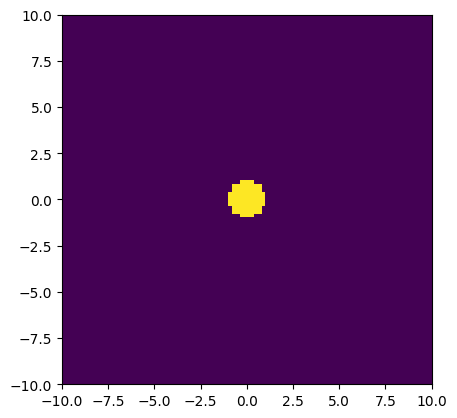

In [11]:
I = np.linspace(-Lx,Lx,Nx); J = np.linspace(-Ly,Ly,Ny).reshape(-1,1); Time = np.arange(0,Nt)

fig, ax = plt.subplots()
ax.imshow(V(I,J,0),extent=[-Lx, Lx, -Ly, Ly] )

In [12]:


psi, diff_norm, Ener = dynamics_2D(psi0_fun=psi0,V_fun=V, Lx=Lx,Ly=Ly, Nx=Nx, Ny=Ny, T=T, Nt=Nt,show=show_sol, f=f)

#### Si problème de mémoire -> red_x,red_y et/ou savefile


C:\Users\user\AppData\Local\Temp\ipykernel_6252\3795047936.py:76: RuntimeWarning: divide by zero encountered in log
  diff_Norm[int(i/savefile)]  = np.log(np.abs(norm -Norme(Nx,Ny,Lx,Ly, Psi_temp[:,:,1])))


5 -inf 76970.71935814647
10 -34.657359027997266 102547.10853591346
15 -34.657359027997266 114005.85637318785
20 -33.96421184743732 116607.64046301568
25 -33.55874673932916 109345.27606024267
30 -33.27106466687737 105169.28864537993
35 -34.657359027997266 103200.70493123075
40 -33.04792111556316 104580.50791205872
45 -32.57791748631743 104019.15740166305
50 -32.460134450661045 103600.96395730958
55 -32.460134450661045 103514.87390546827
60 -32.460134450661045 103621.75940021605
65 -32.460134450661045 104172.42518202733
70 -32.172452378209265 106546.63738713862
75 -31.82414568394105 81248.44303572456
80 -32.172452378209265 55798.46828215745
85 -31.712920048830824 44595.00469260613
90 -31.82414568394105 46995.73347356671
95 -32.172452378209265 46328.203259518436
100 -31.82414568394105 46316.95877871619
105 -31.82414568394105 53439.240412920124
110 -31.884770305757485 57489.10297501122
115 -32.018301698382004 64200.11390262673
120 -31.56631657463895 66686.25845831183
125 -31.82414568394105

In [13]:

Nx_2 = int((Nx/2)*(Nx%2==0) + ((Nx-1)/2)*(Nx%2==1)) 
Ny_2 = int((Ny/2)*(Ny%2==0) + ((Ny-1)/2)*(Ny%2==1))

m = min(0, np.min(np.real(psi)), np.min(np.imag(psi)))
M = np.max(np.abs(psi))

print(m,M)
    

anime = plot_psi_2D(psi,Lx=Lx,   Ly=Ly, duration=2*T, frames_per_second=60)


## tranche de la simulation en (x,0) ou (0,y)
# anime = plot_psi_1D(psi[:,Ny_2,:], L=Lx,  duration=2*T, frames_per_second=60)
# anime = plot_psi_1D(psi[Nx_2,:],   L=Ly,  duration=2*T, frames_per_second=60)
plt.close()
anime

-2.2238383692174506 2.5190772472354466
